# A neuroscience example: the Wilson-Cowan model

In this case, let's consider the activity of two neuron populations: one inhibitory, one excitatory. We work with their firing rates averaged over some short time span, calling the two variables $E(t)$ (excitatory activity) and $I(t)$ (inhibitory activity). We can put them together in a vector $\mathbf{y} = (E, I)$. Then

$$\left\{\begin{matrix}
\dot E = -E + (1-rE)\,S_e(aE - bI + i)\\ 
\dot I = -I + (1-rI)\,S_i(cE - dI + i)
\end{matrix}\right.$$

Let's break this down:
- The $-E$ and $-I$ terms mean "the activity tends to die out on its own".
- The term inside $aE-bI + i$ and the equivalent one for $I$ are the inputs to the two populations, which depend on:
    - recurrent input: the excitation and inhibition from the two populations
    - the external input $i$
- $S$ is a nonlinear function, that shows neurons respond non-linearly to their input
- The term $(1-rE)$ tells us that neurons have a refractory period, and cannot fire with rates above a certain value $1/r$.

### Defining parameters

In [10]:
import numpy as np

# couplings
a = 16
b = 12
c = 15
d = 3

# refractory periods
rE = 1
rI = 1
r = 1

# external inputs
inpt = 1

# simulation time
time = np.linspace(0, 50, 1000)

### Defining the functions and equations

Here, we define the response function, and a function that computes the derivatives.

In [11]:
# nonlinear functions
from scipy.special import expit

# the excitatory and inhibitory populations can have different response functions
def exc_response(x):
    return expit(4*(x-1.3)) - 0.00549

def inh_response(x):
    return expit(3.7*(x-2)) - 0.00061


# this function returns the right hand side of the Wilson-Cowan equation
# (both, in a 2-vector)
def WilsonCowan(y, t):
    E = y[0]
    I = y[1]
    E_dot = -E + (1 - r * E) * exc_response(a * E - b * I + inpt)
    I_dot = -I + (1 - r * I) * inh_response(c * E - d * I + inpt)
    return [E_dot, I_dot]

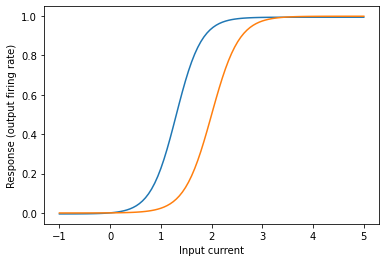

In [12]:
# plot just to show how they look
import matplotlib.pyplot as plt

x = np.linspace(-1, 5, 100)
plt.plot(x, exc_response(x), label="Exc response function")
plt.plot(x, inh_response(x), label="Inh response function")
plt.xlabel("Input current")
plt.ylabel("Response (output firing rate)");

## Functions for numerical solution of ODEs
We won't go into the details of how these work.

Instead of forward Euler, in this case we will use some powerful functions from the Scipy library.

In [8]:
from scipy.optimize import fsolve
from scipy.integrate import odeint

def find_flow_field():
    # minimum and maximum E and I values we want displayed in the graph
    minval = -.1
    maxval = .6
    resolution = 20

    # State variables
    vals = np.linspace(minval, maxval, resolution)

    # Create a grid for evaluation of the vector field
    E_vals, I_vals = np.meshgrid(vals, vals)

    # Evaluate the derivatives
    E_dot, I_dot = WilsonCowan([E_vals, I_vals], 0)
    
    return E_dot, I_dot

def find_fixed_points():
    fixed_p = []
    y1 = E_vals.ravel()
    y2 = I_vals.ravel()
    for i in range(resolution**2):
        # find a zero
        sol, infodict, ier, mesg = fsolve(
            WilsonCowan, [y1[i], y2[i]], args=(0), full_output=1)
        if ier == 1: # I exclude the cases where fsolve didn't converge
            fixed_p.append(sol)

    return np.array(fixed_p).T

def solve_eq_diffs(E0, I0, time):  # the inputs are the starting points
    # find the solution with scint.odeint
    odesol = odeint(WilsonCowan, [E0, I0], time)
    # separate the two solutions
    exc_timeseries, inh_timeseries = odesol.T
    return exc_timeseries, inh_timeseries

## Finding a solution given initial conditions

In [55]:
# initial conditions
E0, I0 = 0.39, 0.49 # try changing this

exc_timeseries, inh_timeseries = solve_eq_diffs(E0, I0, time)

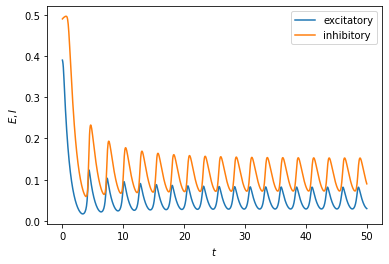

In [56]:
import matplotlib.pyplot as plt

# plot the solution in time
plt.ylabel(r'$E, I$')
plt.xlabel(r'$t$')
plt.plot(time, exc_timeseries, '-', label="excitatory");
plt.plot(time, inh_timeseries, '-', label="inhibitory");
plt.legend();

### Exercise

- What do we see here? What is the neural network doing?
- Try changing the initial conditions `E0, I0`. Can you get it to have a different behavior?

## Plotting the phase portrait

Let's now compute the whole flow field and show it in phase space.

Additionally, we can use a numerical equation solver to find the equilibrium points.

In [57]:
# compute the vector field corresponding to the equation
E_dot, I_dot = find_flow_field()

# numerically find the fixed points of this field
fixed_p = find_fixed_points()

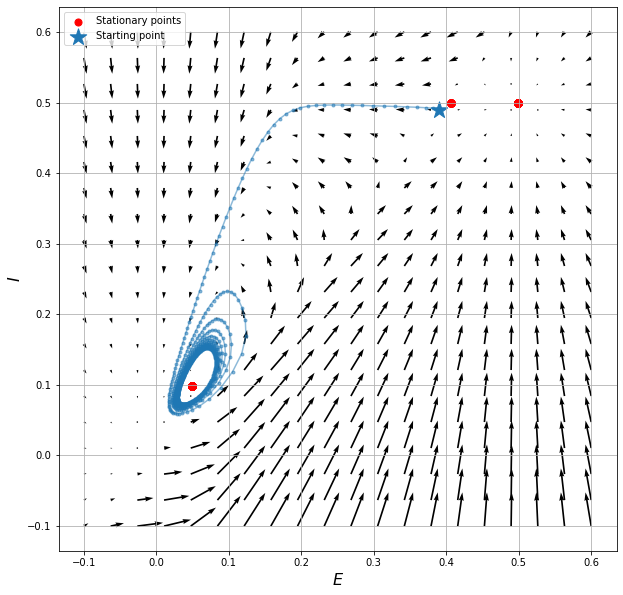

In [59]:
# plotting the vector field in the state space (E, I)
plt.figure(figsize=(10, 10))
plt.quiver(E_vals, I_vals, E_dot, I_dot)
plt.xlabel(r'$E$', fontsize=16) # yes, you can use Latex code!
plt.ylabel(r'$I$', fontsize=16)
plt.grid()

# plot the solution in the phase space
plt.plot(exc_timeseries, inh_timeseries, '.-', alpha=0.5);

# plot the fixed points we identified
plt.scatter(fixed_p[0], fixed_p[1], marker='o', s=50, c='r',
            label="Stationary points")

# plot the starting point
plt.scatter(E0, I0, marker='*', s=300, label="Starting point")
plt.legend(loc="upper left");

### Final considerations

What do we observe? Equilibrium points? Stable or unstable? Limit cycles? What do we conclude?

# Exercise for another time: prey-predator model
Let us extend our example of the logistic equation to multiple populations. This was the equation we used so far:
$$ \frac{dy(t)}{dt} = ky(t)\cdot (M - y(t)) = kMy - ky^2 $$

But let's think of this as a population of preys (for example, zebras). The limiting factor, in this case, is due to a population of predators (lions).
$$ \frac{dZ(t)}{dt} = rZ(t) - aZ(t)L(t)$$
$$ \frac{dL(t)}{dt} = -mZ(t) + bZ(t)L(t)$$
We should interpret these terms as follows:
- The Zebras reproduce at rate $r$ in absence of lions
- The Lions dwindle with mortality $m$ in absence of zebras
- The Zebras tend to die more in presence of lions (by a factor $a$)
- The Lions tend to reproduce more in presence of zebras (by a factor $b$).

These are called **Lotka-Volterra equations** and are often used as an example of a system with richer dynamics.

Exercise: plot the phase portrait and interpret it.